In [2]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [3]:
client = InfluxDBClient(host='140.112.42.158', port=8086, database='test_2')

In [4]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'ko': 'Korean', 
        'ja': 'Japan',
        'es': 'Spanish',
        'fr': 'French',
        'ru': 'Russian',
        'west-us': 'West US',
        'US': 'United States',
        'SG': 'Singapore',
        'GB': 'Great Britain',
        'NL': 'Netherlands',
        'HK': 'Hong Kong'
    }

In [5]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

#### Calculate gorund truth

In [6]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='west-us')
result = client.query(q)

ground_truth, _ = get_edge_num(result) # total # of edge servers

In [7]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='west-us')
result = client.query(q)

M, _ = get_edge_num(result) # number of edge servers in first capture

In [8]:
START_T = '2019-11-01T20:00:00Z' # start time
END_T = '2019-11-01T21:00:00Z'   # end time
q = build_query(START_T, END_T, loc='west-us')
result = client.query(q)

C, _ = get_edge_num(result) # number of edge servers in second capture

#### Calculate intersection of edge servers between two captures 

In [9]:
R = M.intersection(C)
print(len(R))

50


#### Estimate total number of servers by CRC: $N=\dfrac{MC}{R}$

In [10]:
N = (len(M)*len(C))//len(R)
print(N)

68


#### Input whole week data 

In [11]:
def get_estimation(date, date_1, t1, t2, loc, lang):
    st = f'2019-11-{date}T00:00:00Z' 
    et = f'2019-11-{date_1}T00:00:00Z'
    m_st = f'2019-11-{date}T08:00:00Z'
    m_et = f'2019-11-{date}T{t1}Z'
    c_st = f'2019-11-{date}T16:00:00Z'
    c_et = f'2019-11-{date}T{t2}Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result) 
    
    q = build_query(m_st, m_et, loc=loc, lang=lang)
    result = client.query(q)
    M, M_t = get_edge_num(result) 
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    R = M.intersection(C)
    
    try:
        N = len(M)*len(C)/len(R)
    except ZeroDivisionError:
        N = 0
    
    return int(N), len(gt), gt_t, (M_t+C_t)

In [12]:
date =   ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
date_1 = ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']
time_2 = ['16:15:00', '16:30:00', '17:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [13]:
gt = [141, 128, 152, 133, 140, 152, 128, 130, 131, 129]
est = [[], [], [], [], [], [], []]
trans = [[], [], [], [], [], [], []]
error = []
error_daily = [[], [], [], [], [], [], []]

for i, (t1, t2) in enumerate(zip(time_1, time_2)):
    err = 0
    for d, d1 in zip(date, date_1):
        N, gt, gt_t, t = get_estimation(d, d1, t1, t2, 'west-us', None)
        print(N, gt, t, gt_t)
        
        est[i].append(N)
        trans[i].append(t)
        
        err += (N-gt)**2
        error_daily[i].append(N-gt)
    err = (err/len(date))**(1/2)
    print(err)
    error.append(err)

51 141 7315 327913
51 128 9252 315358
74 152 7951 291054
88 133 8422 320451
50 140 6961 317502
93 152 7434 278662
96 128 6909 284515
50 130 6644 212132
88 131 6883 260809
110 129 6838 264912
65.84299507160955
51 141 16864 327913
51 128 17281 315358
105 152 15761 291054
88 133 15485 320451
50 140 14224 317502
114 152 13282 278662
114 128 12705 284515
51 130 11931 212132
102 131 13101 260809
114 129 12524 264912
59.42221806698232
60 141 31005 327913
105 128 32219 315358
114 152 29057 291054
124 133 28677 320451
50 140 27538 317502
119 152 25829 278662
124 128 24356 284515
114 130 24318 212132
125 131 24048 260809
121 129 23611 264912
42.63332030231753
123 141 61771 327913
127 128 59530 315358
126 152 60206 291054
143 133 59836 320451
92 140 55493 317502
137 152 50455 278662
125 128 48485 284515
119 130 50499 212132
126 131 49920 260809
123 129 49062 264912
19.547378340841515
129 141 113848 327913
128 128 114967 315358
152 152 113193 291054
131 133 114395 320451
162 140 106109 317502
139 

In [14]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

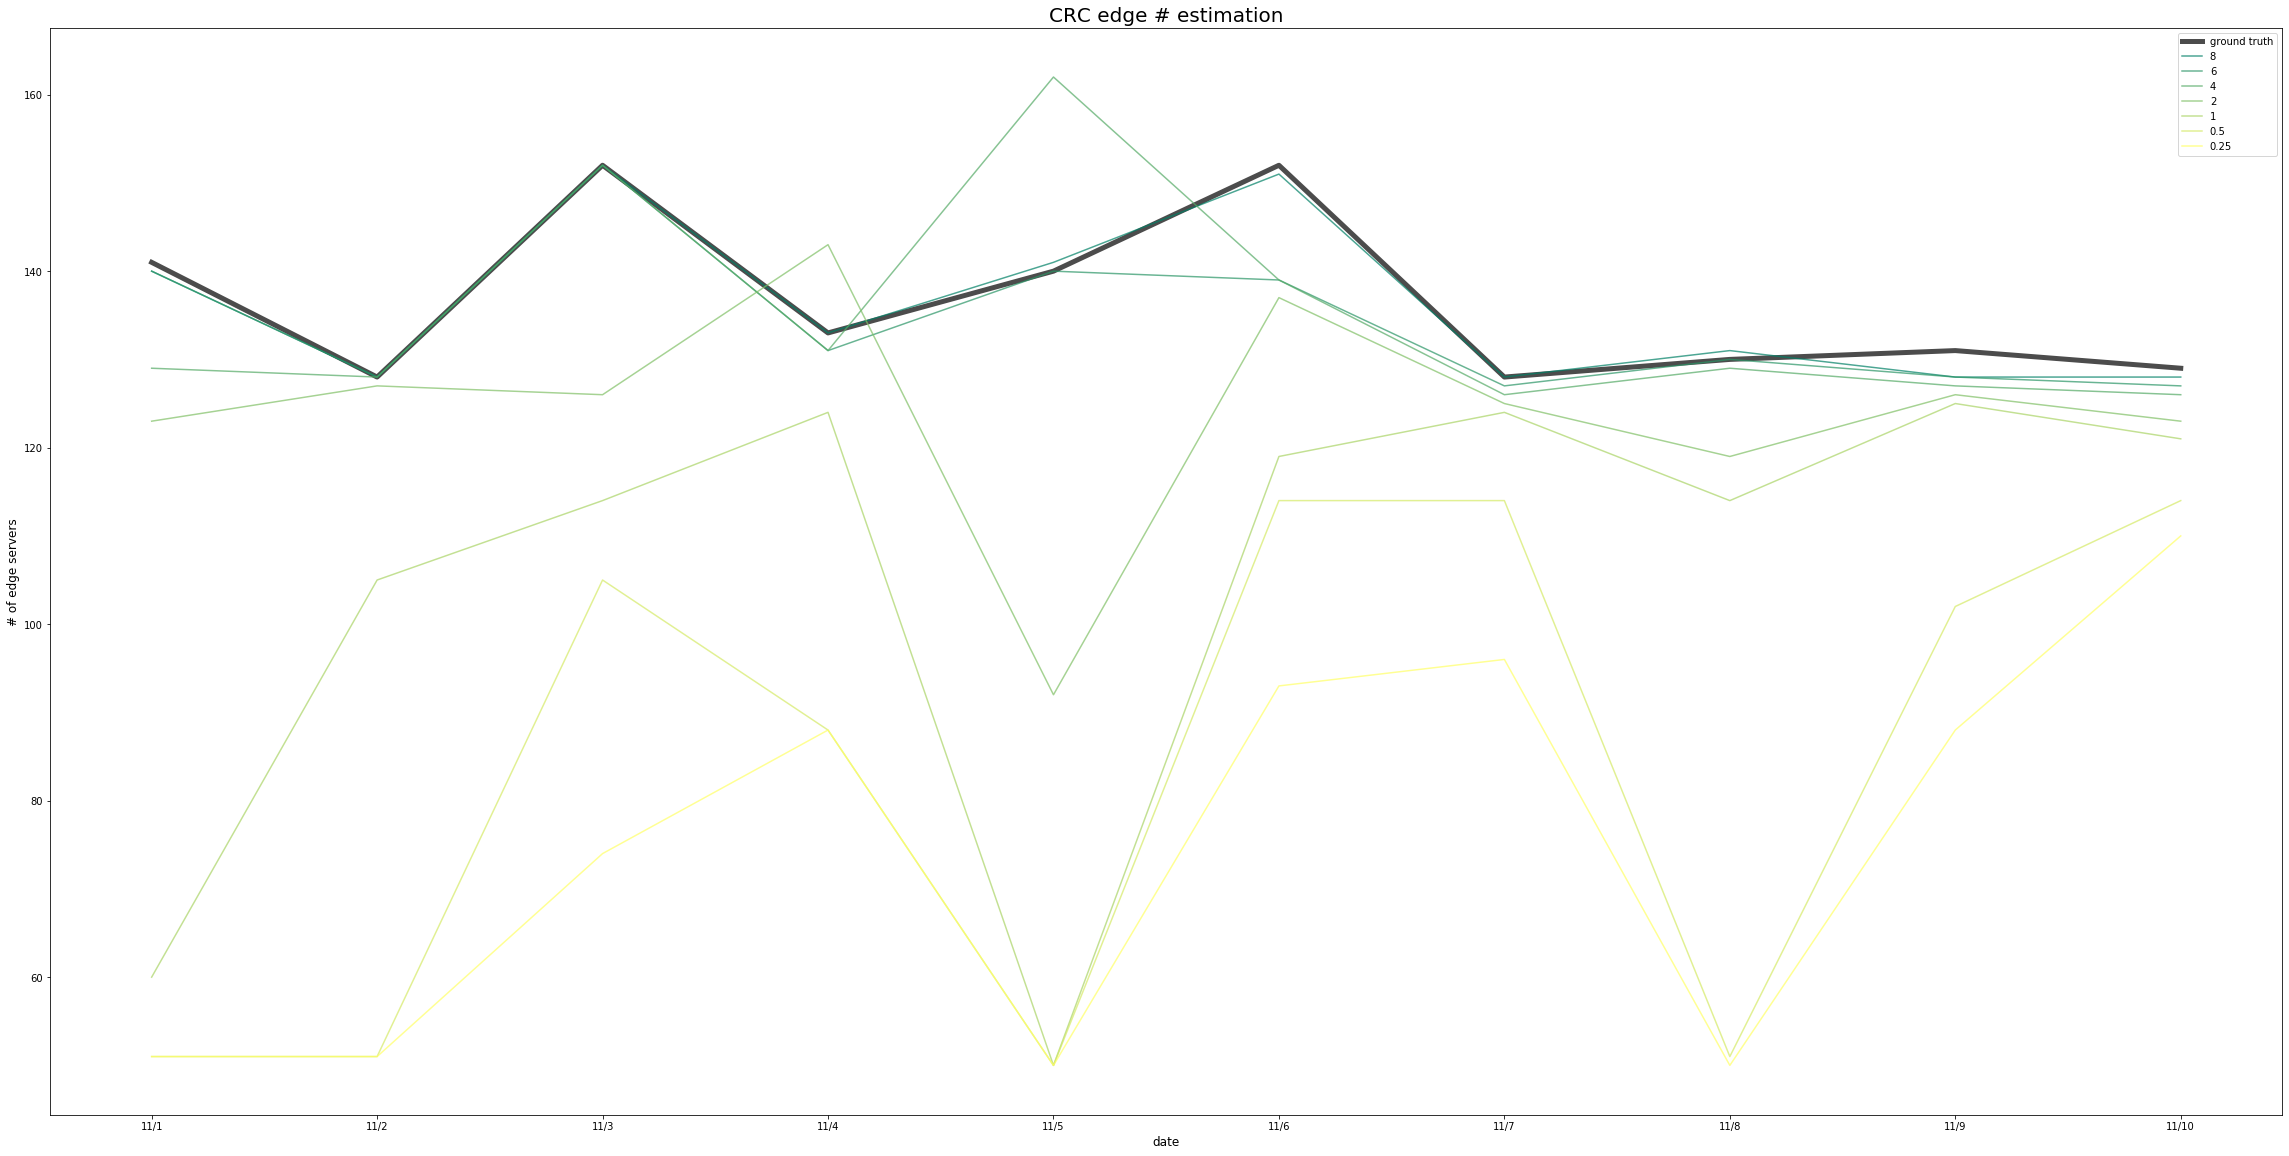

In [19]:
gt = [141, 128, 152, 133, 140, 152, 128, 130, 131, 129]
fig, ax = plt.subplots(figsize=(40, 20))
# x_axis = list(range(len(gt)))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/6', '11/7', '11/8', '11/9', '11/10']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of edge servers', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, est[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('CRC edge # estimation', fontsize=20)
plt.legend()
plt.show()


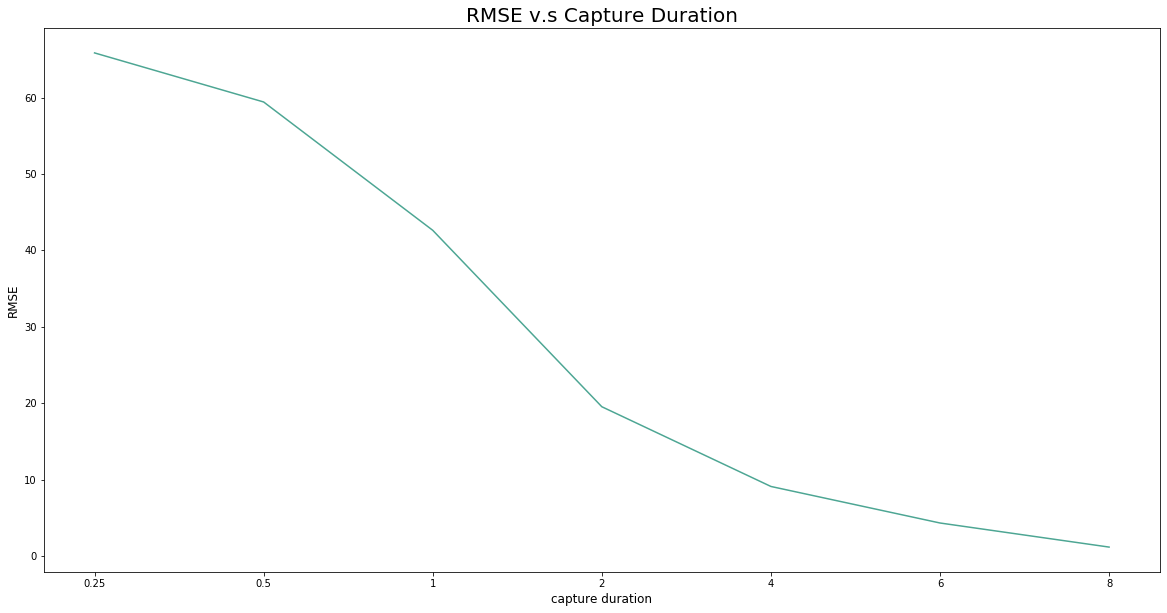

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']

ax.set_xlabel('capture duration', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, error, color=plt.cm.summer(1), alpha=0.7)
plt.title('RMSE v.s Capture Duration', fontsize=20)

plt.show()

#### TODO: Plot # of reduction in transactions

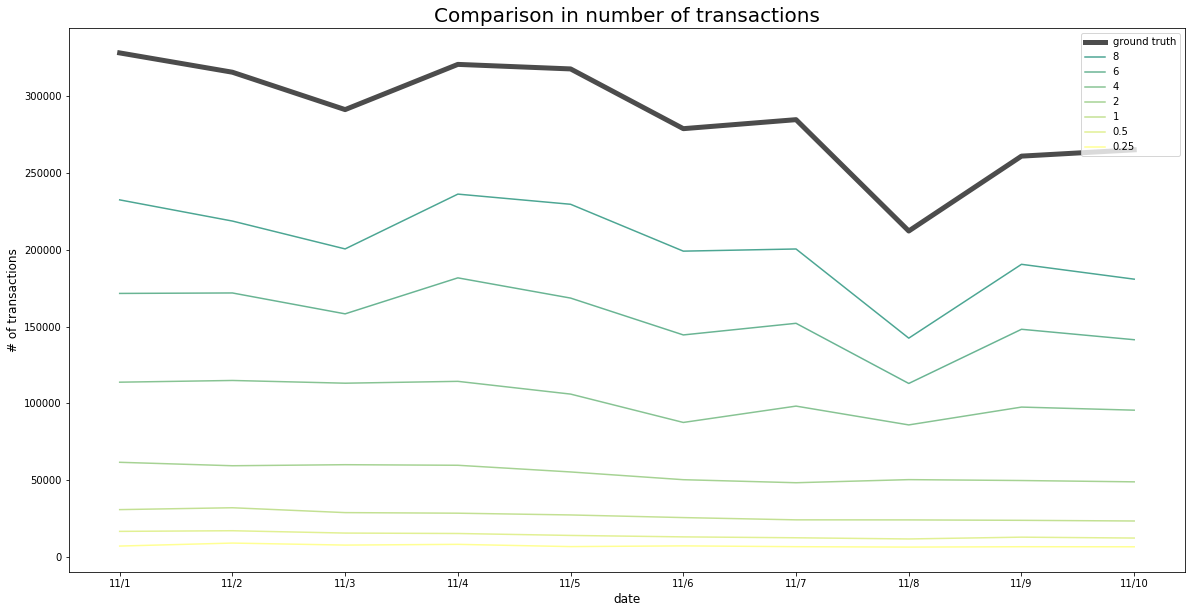

In [25]:
trans_gt = [327913, 315358, 291054, 320451, 317502, 278662, 284515, 212132, 260809, 264912]
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/6', '11/7', '11/8', '11/9', '11/10']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of transactions', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, trans_gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, trans[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('Comparison in number of transactions', fontsize=20)
plt.legend(loc='upper right')
plt.show()

In [26]:
trans_date = list(zip(*trans))
per = [[round(t/gt, 3) for t in td] for (gt, td) in zip(trans_gt, trans_date)]
per = list(zip(*per)) 
print(per)

[(0.022, 0.029, 0.027, 0.026, 0.022, 0.027, 0.024, 0.031, 0.026, 0.026), (0.051, 0.055, 0.054, 0.048, 0.045, 0.048, 0.045, 0.056, 0.05, 0.047), (0.095, 0.102, 0.1, 0.089, 0.087, 0.093, 0.086, 0.115, 0.092, 0.089), (0.188, 0.189, 0.207, 0.187, 0.175, 0.181, 0.17, 0.238, 0.191, 0.185), (0.347, 0.365, 0.389, 0.357, 0.334, 0.315, 0.345, 0.406, 0.374, 0.361), (0.523, 0.545, 0.544, 0.567, 0.531, 0.519, 0.535, 0.533, 0.568, 0.534), (0.709, 0.693, 0.689, 0.737, 0.723, 0.714, 0.705, 0.672, 0.73, 0.683)]


#### Box plot of *error rate* and *reduction percentage*

In [27]:
error_daily = [tuple([abs(e)for e in err]) for err in error_daily]
print(gt)
error_daily_per = [[e/gt[i] for i, e in enumerate(err)] for err in error_daily]

[141, 128, 152, 133, 140, 152, 128, 130, 131, 129]


In [28]:
print(per)
print(error_daily)
print(error_daily_per)

[(0.022, 0.029, 0.027, 0.026, 0.022, 0.027, 0.024, 0.031, 0.026, 0.026), (0.051, 0.055, 0.054, 0.048, 0.045, 0.048, 0.045, 0.056, 0.05, 0.047), (0.095, 0.102, 0.1, 0.089, 0.087, 0.093, 0.086, 0.115, 0.092, 0.089), (0.188, 0.189, 0.207, 0.187, 0.175, 0.181, 0.17, 0.238, 0.191, 0.185), (0.347, 0.365, 0.389, 0.357, 0.334, 0.315, 0.345, 0.406, 0.374, 0.361), (0.523, 0.545, 0.544, 0.567, 0.531, 0.519, 0.535, 0.533, 0.568, 0.534), (0.709, 0.693, 0.689, 0.737, 0.723, 0.714, 0.705, 0.672, 0.73, 0.683)]
[(90, 77, 78, 45, 90, 59, 32, 80, 43, 19), (90, 77, 47, 45, 90, 38, 14, 79, 29, 15), (81, 23, 38, 9, 90, 33, 4, 16, 6, 8), (18, 1, 26, 10, 48, 15, 3, 11, 5, 6), (12, 0, 0, 2, 22, 13, 2, 1, 4, 3), (1, 0, 0, 2, 0, 13, 1, 0, 3, 2), (1, 0, 0, 0, 1, 1, 0, 1, 3, 1)]
[[0.6382978723404256, 0.6015625, 0.5131578947368421, 0.3383458646616541, 0.6428571428571429, 0.3881578947368421, 0.25, 0.6153846153846154, 0.3282442748091603, 0.14728682170542637], [0.6382978723404256, 0.6015625, 0.3092105263157895, 0.3383

In [29]:
per_mean = [100*mean(l) for l in per]
error_daily_mean = [mean(l) for l in error_daily]
error_daily_per_mean = [100*mean(l) for l in error_daily_per]

print(per_mean)
print(error_daily_mean)
print(error_daily_per_mean)

[2.6, 4.989999999999999, 9.479999999999999, 19.11, 35.93, 53.99, 70.55]
[61.3, 52.4, 30.8, 14.3, 5.9, 2.2, 0.8]
[44.63294881232109, 38.34994329436289, 21.939311177242008, 10.159864808089623, 4.199206226868508, 1.5387324768376727, 0.5915901212842092]


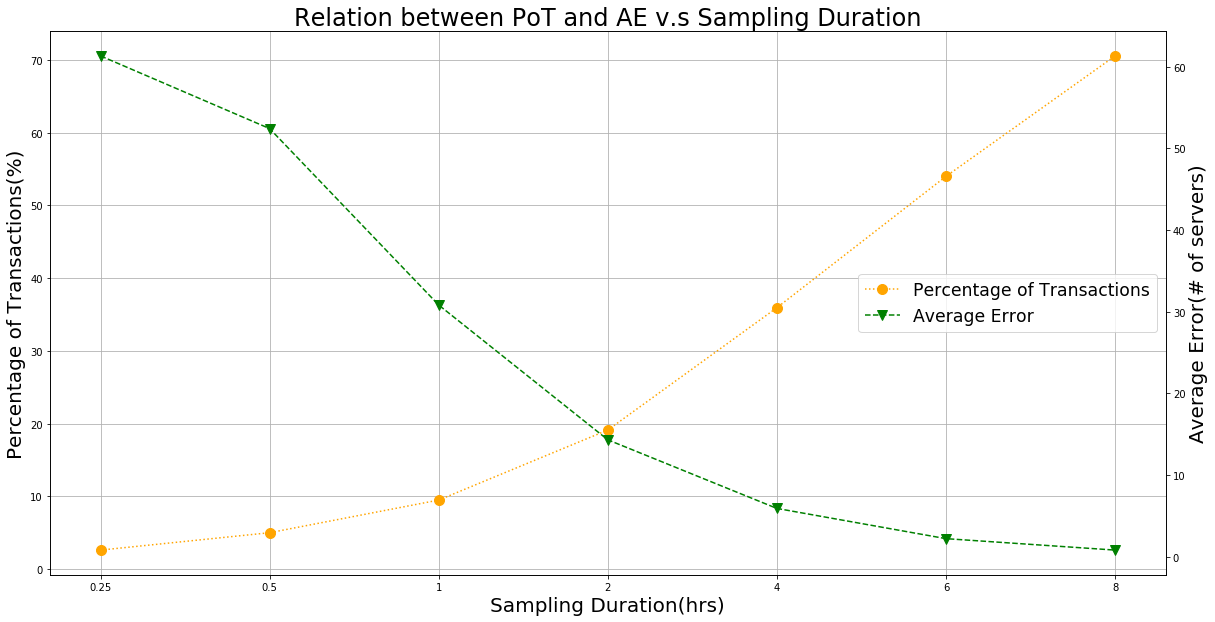

In [30]:
fig, ax1 = plt.subplots(figsize=(20, 10))
labels = ['0.25', '0.5', '1', '2', '4', '6', '8']

# mirror axis 
ax2 = ax1.twinx()

ln1 = ax1.plot(labels, per_mean, label='Percentage of Transactions', linestyle=':', color='orange', marker='o', markersize=10)
ln2 = ax2.plot(labels, error_daily_mean, label='Average Error', linestyle='--', color='green', marker='v', markersize=10)

# make labels appear in one legend
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize = 'xx-large')

ax2.set_ylabel('Average Error(# of servers)', fontsize=20)
ax1.set_ylabel('Percentage of Transactions(%)', fontsize=20)
ax1.set_xlabel('Sampling Duration(hrs)', fontsize=20)
ax1.set_title('Relation between PoT and AE v.s Sampling Duration', fontsize=24)

ax1.grid()
plt.show()

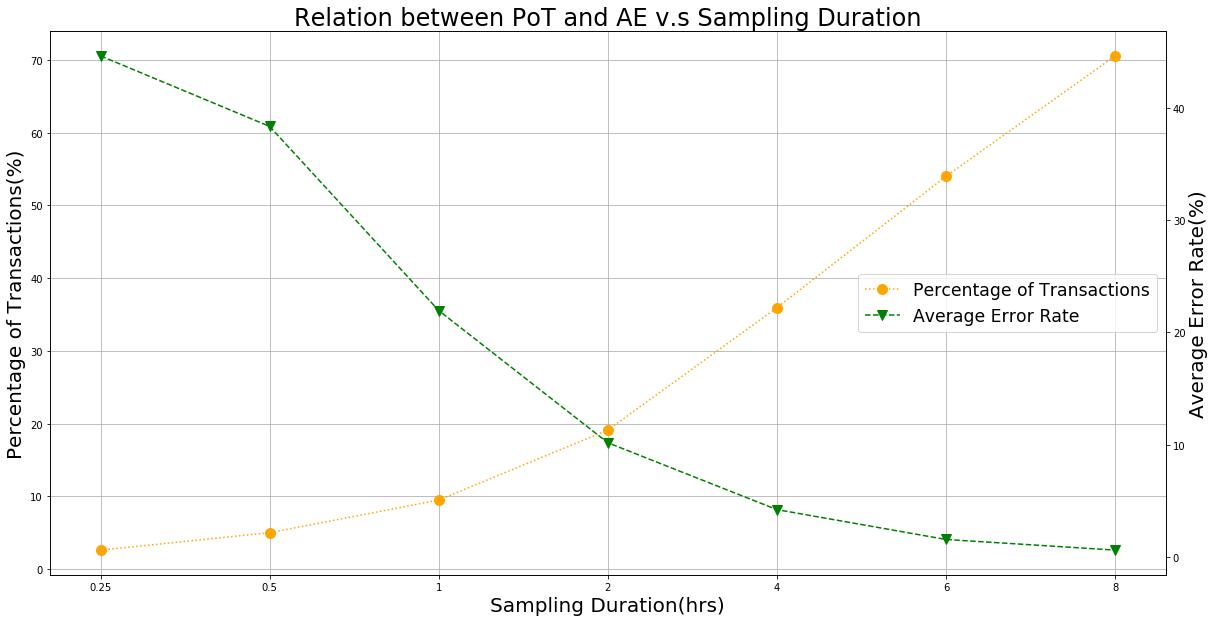

In [31]:
fig, ax1 = plt.subplots(figsize=(20, 10))
labels = ['0.25', '0.5', '1', '2', '4', '6', '8']

# mirror axis 
ax2 = ax1.twinx()

ln1 = ax1.plot(labels, per_mean, label='Percentage of Transactions', linestyle=':', color='orange', marker='o', markersize=10)
ln2 = ax2.plot(labels, error_daily_per_mean, label='Average Error Rate', linestyle='--', color='green', marker='v', markersize=10)

# make labels appear in one legend
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize = 'xx-large')

ax2.set_ylabel('Average Error Rate(%)', fontsize=20)
ax1.set_ylabel('Percentage of Transactions(%)', fontsize=20)
ax1.set_xlabel('Sampling Duration(hrs)', fontsize=20)
ax1.set_title('Relation between PoT and AE v.s Sampling Duration', fontsize=24)

ax1.grid()
plt.show()

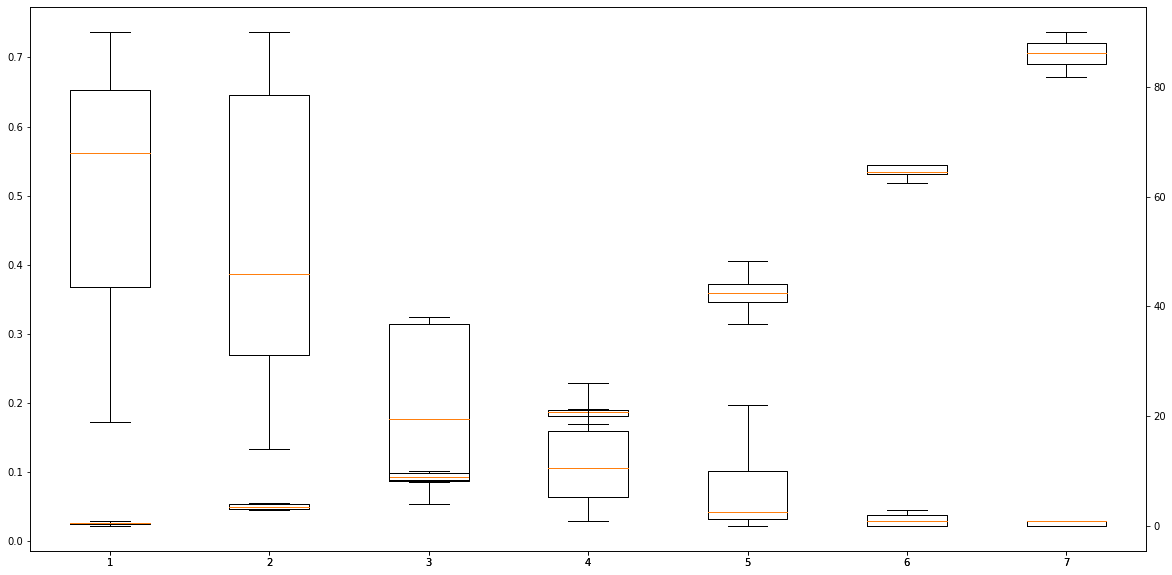

In [32]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.boxplot(per, 0, '')
ax2.boxplot(error_daily, 0, '')


plt.show()